In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

import sympy

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& u_x+v_y=0 ,\\[4pt]
F^2:& u_t + u u_x+v u_y + p_x -\frac{1}{\mathrm{Re}}\nabla^2 u = 0 ,\\[4pt]
F^3:& v_t + u v_x+v v_y + p_y - \frac{1}{\mathrm{Re}}\nabla^2 v = 0 .
\end{array}
\right. 
\end{equation}
Пусть $p \succ u \succ v$ и $t \succ x \succ y$. Введем допустимое упорядочение таким способом, что
любая производная по $t$ старше любой другой производной, а затем сравниваем
для все равного какого допустимого упорядочения по \emph{POT}.
Тогда лидирующими членами для системы выше будут соответственно $u_x,\, u_t,\, v_t$ 
и можно будет построить следующий $S$-полином:
\begin{equation}
 \left(F^2_x -  F^1_t\right) + F^3_y + \frac{1}{\mathrm{Re}}\nabla^2 F^1
 = \left(uu_x+vu_y\right)_x + \left(u v_x+v v_y\right)_y + \nabla^2 p  .
\end{equation}
В результате получим инволютивную систему:
\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& u_x+v_y=0 ,\\[4pt]
F^2:& u_t + u u_x+v u_y + p_x -\frac{1}{\mathrm{Re}}\nabla^2 u = 0 ,\\[4pt]
F^3:& v_t + u v_x+v v_y + p_y - \frac{1}{\mathrm{Re}}\nabla^2 v = 0,\\[4pt]
F^4:& \left(uu_x+vu_y\right)_x + \left(u v_x+v v_y\right)_y + \nabla^2 p=0 ,
\end{array}
\right. 
\end{equation}
где лидирующими членами будут соответственно $u_x,\, u_t,\, v_t,\, p_{xx}$.
Инволютивную систему можно переписать в виде законов сохранения:
\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{div}(u,\, v)=0 ,\\[4pt]
F^2:& u_t + \operatorname{div}\left(u^2+p-\frac{1}{\mathrm{Re}}u_x,\, vu -\frac{1}{\mathrm{Re}}u_y\right)=0 ,\\[4pt]
F^3:& v_t + \operatorname{div}\left(uv-\frac{1}{\mathrm{Re}}v_x,\, v^2+p -\frac{1}{\mathrm{Re}}v_y\right)=0,\\[4pt]
F^4:& \operatorname{div}\left(uu_x+vu_y+p_x,\, uv_x+vv_y+p_y\right)=0 .
\end{array}
\right. 
\end{equation}

Неявная схема

$
\operatorname{D_i} = \dfrac{\sigma_i - \sigma_i^{-1}}{2h}, \ 
\operatorname{D_t} = \dfrac{\sigma_t - 1}{\tau}, \ 
\tilde{\Delta} = \dfrac{\sigma_1 - 2 + \sigma_1^{-1}}{h^2} + \dfrac{\sigma_2 - 2 + \sigma_2^{-1}}{h^2}, \ 
\operatorname{I_t} = \dfrac{\sigma_t + 1}{2} .
$

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{I_t}\left(\operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + \operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
\right)=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{I_t}\left(\operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) + \operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
\right)=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2 \right)(p) + \operatorname{D_1}^2(u^2)
+ 2\operatorname{D_1}\operatorname{D_2}(uv)+ \operatorname{D_2}^2(v^2)=0 .
%-\frac{1}{\mathrm{Re}} \tilde{\nabla}^2\left(\operatorname{D_1}(u)+ \operatorname{D_2}(v) \right)
\end{array}
\right. 
\end{equation}
$S$-полином
\begin{equation}
 \left(\operatorname{D_1}(F^2) -  \operatorname{D_t}(F^1)\right) + \operatorname{D_2}(F^3)
 + \operatorname{I_t}\left(\frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)\right) - \operatorname{I_t}(F^4) = 0 .
\end{equation}

Построение простой итерации для полиномиалного вида $F(x)$
$$
\begin{array}{l}
u^2 = u^2 - u'^2 + u'^2 = (u-u')(u+u') +
\\ \quad {} 
+u'^2 \approx (u-u') 2u' + u'^2= 2uu' - u'^2 \\
uv = ((u+v)^2 - (u-v)^2)/4 \approx
((2(u+v)(u'+v') - (u'+v')^2) -
{} \hfill \\ \hfill {}
- (2(u-v)(u'-v') - (u'-v')^2))/4 = uv'+u'v-u'v' \\
u^3 = u^3 - u'^3 + u'^3 = (u-u')(u^{2} + u u' + u'^{2}) +
{} \hfill \\ \hfill {}
+u'^3 \approx (u-u') 3u'^2 + u'^2= 3uu'^2 - 2u'^3
\end{array}
$$
Пример общего правила (3 - полная степень):
$$
\begin{array}{l}
u^2 v = u u v \approx u' u' v + u u' v' + u' u v'-
{} \hfill \\ \hfill {}
- (3 - 1) u'^2v'= u'^2 v + 2uu'v' - 2u'^2v'
\end{array}
$$

In [2]:
def Dx(a):
    return a[3:-1,2:-2] - a[1:-3,2:-2]
def Dy(a):
    return a[2:-2,3:-1] - a[2:-2,1:-3]

def DD(a):
    return a[3:-1,2:-2] + a[2:-2,3:-1] +\
       -4.*a[2:-2,2:-2] +\
           a[1:-3,2:-2] +a[2:-2,1:-3]
def Dxx(a):
    return a[4:,2:-2] - 2.*a[2:-2,2:-2] + a[:-4,2:-2]
def Dxy(a):
    return a[3:-1,3:-1] - a[3:-1,1:-3] - a[1:-3,3:-1] + a[1:-3,1:-3]
def Dyy(a):
    return a[2:-2,4:] - 2.*a[2:-2,2:-2] + a[2:-2,:-4]

In [3]:
def solve(F, x, y, Re, tau, t1):
    """
    f - точное решение
    x, y - сетка по x и y
    Re - число Рейнольдса
    tau, h - шаг по t, шаг по x
    t1 - конечное время
    n - число шагов по времени в выводе
    """
    assert x.shape == y.shape
    Nx, Ny = x.shape
    assert 23 <= Nx and 23 <= Ny
    h = x[1, 0] - x[0, 0]
    assert h == y[0, 1] - y[0, 0]
    Nxy = Nx*Ny

    # вспомогательные массивы для задания разреженной матрицы
    row = empty((3, Nx, Ny, 23), dtype=int32)
    col = zeros((3, Nx, Ny, 23), dtype=int32)
    data = zeros((3, Nx, Ny, 23), dtype=float64)
    # столбец свободных членов
    b = zeros((3, Nx, Ny), dtype=float64)

    def jkU(j, k): # u
        return j*Ny+k
    def jkV(j, k): # v
        return j*Ny+k + Nxy
    def jkP(j, k): # p
        return j*Ny+k + 2*Nxy
    
    for j in range(Nx):
        for k in range(Ny):
            row[0, j, k] = jkU(j, k)
    row[1] = row[0] + Nxy
    row[2] = row[0] + 2*Nxy
    
    for j in range(2, Nx-2):
        for k in range(2, Ny-2):
            col[0, j, k, :9] = jkU(j+1, k), \
                  jkU(j, k+1), jkU(j, k),  jkU(j, k-1),\
                               jkU(j-1, k), \
                        jkV(j, k+1), jkV(j, k-1),\
                        jkP(j+1, k), jkP(j-1, k)
            col[1, j, k, :9] = jkV(j+1, k), \
                  jkV(j, k+1), jkV(j, k),  jkV(j, k-1),\
                               jkV(j-1, k), \
                        jkU(j+1, k), jkU(j-1, k),\
                        jkP(j, k+1), jkP(j, k-1)
            col[2, j, k] = jkP(j+2, k), \
              jkP(j, k+2), jkP(j, k),  jkP(j, k-2),\
                           jkP(j-2, k), \
                           jkU(j+2, k), \
                   jkU(j+1, k+1), jkU(j-1, k+1),\
              jkU(j, k+2), jkU(j, k),  jkU(j, k-2),\
                   jkU(j+1, k-1), jkU(j-1, k-1),\
                           jkU(j-2, k), \
                           jkV(j+2, k), \
                   jkV(j+1, k+1), jkV(j-1, k+1),\
              jkV(j, k+2), jkV(j, k),  jkV(j, k-2),\
                   jkV(j+1, k-1), jkV(j-1, k-1),\
                           jkV(j-2, k)
    for j in range(Nx):
        col[0, j, :2, 0] = jkU(j, 0), jkU(j, 1)
        col[0, j, -2:, 0] = jkU(j, Ny-2), jkU(j, Ny-1)
        col[1, j, :2, 0] = jkV(j, 0), jkV(j, 1)
        col[1, j, -2:, 0] = jkV(j, Ny-2), jkV(j, Ny-1)
        col[2, j, :2, 0] = jkP(j, 0), jkP(j, 1)
        col[2, j, -2:, 0] = jkP(j, Ny-2), jkP(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, :2, k, 0] = jkU(0, k), jkU(1, k)
        col[0, -2:, k, 0] = jkU(Nx-2, k), jkU(Nx-1, k)
        col[1, :2, k, 0] = jkV(0, k), jkV(1, k)
        col[1, -2:, k, 0] = jkV(Nx-2, k), jkV(Nx-1, k)
        col[2, :2, k, 0] = jkU(0, k), jkU(1, k)
        col[2, -2:, k, 0] = jkP(Nx-2, k), jkP(Nx-1, k)

    # за нормировку строк матрицы взято O(1)
    # граничные условия
    data[:, 0, :, 0] = 1.
    data[:, -1, :, 0] = 1.
    data[:, 1:-1, 9, 0] = 1.
    data[:, 1:-1, -1, 0] = 1.

    data[:, 1, :, 0] = 1.
    data[:, -2, :, 0] = 1.
    data[:, 2:-2, 1, 0] = 1.
    data[:, 2:-2, -2, 0] = 1.

    h12, h2R = tau/(h*2.), tau/(h**2*Re)
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, v, p = F(0., x, y, Re)
    sol = [(0.0, u, v, p)]
    for i in range(1, int(t1/tau)+1):
        # начало простой итерации для построения v решения для следующего временного слоя
        u1, v1, p1, f, l = copy(u), copy(v), copy(p), True, 0
        
        ui, vi, pi = F(i*tau, x, y, Re)
        
        b[0, 0, :] = ui[0, :]
        b[0, -1, :] = ui[-1, :]
        b[0, 1:-1, 0] = ui[1:-1, 0]
        b[0, 1:-1, -1] = ui[1:-1, -1]
        
        b[0, 1, 1:-1] = ui[1, 1:-1]
        b[0, -2, 1:-1] = ui[-2, 1:-1]
        b[0, 2:-2, 1] = ui[2:-2, 1]
        b[0, 2:-2, -2] = ui[2:-2, -2]
        
        b[1, 0, :] = vi[0, :]
        b[1, -1, :] = vi[-1, :]
        b[1, 1:-1, 0] = vi[1:-1, 0]
        b[1, 1:-1, -1] = vi[1:-1, -1]
        
        b[1, 1, 1:-1] = vi[1, 1:-1]
        b[1, -2, 1:-1] = vi[-2, 1:-1]
        b[1, 2:-2, 1] = vi[2:-2, 1]
        b[1, 2:-2, -2] = vi[2:-2, -2]

        b[2, 0, :] = pi[0, :]
        b[2, -1, :] = pi[-1, :]
        b[2, 1:-1, 0] = pi[1:-1, 0]
        b[2, 1:-1, -1] = pi[1:-1, -1]
        
        b[2, 1, 1:-1] = pi[1, 1:-1]
        b[2, -2, 1:-1] = pi[-2, 1:-1]
        b[2, 2:-2, 1] = pi[2:-2, 1]
        b[2, 2:-2, -2] = pi[2:-2, -2]
        
        while f:
            f = False
            data[0, 2:-2, 2:-2, 0] = 2.*u1[3:-1,2:-2]*h12 - h2R
            data[0, 2:-2, 2:-2, 1] = v1[2:-2,3:-1]*h12 - h2R 
            data[0, 2:-2, 2:-2, 2] = 1. + 4.*h2R
            data[0, 2:-2, 2:-2, 3] = -v1[2:-2,1:-3]*h12 - h2R
            data[0, 2:-2, 2:-2, 4] = -2.*u1[1:-3,2:-2]*h12 - h2R
            data[0, 2:-2, 2:-2, 5] = u1[2:-2,3:-1]*h12
            data[0, 2:-2, 2:-2, 6] = -u1[2:-2,1:-3]*h12
            data[0, 2:-2, 2:-2, 7] = h12
            data[0, 2:-2, 2:-2, 8] = -h12
            
            data[1, 2:-2, 2:-2, 0] = u1[3:-1,2:-2]*h12 - h2R
            data[1, 2:-2, 2:-2, 1] = 2.*v1[2:-2,3:-1]*h12 - h2R
            data[1, 2:-2, 2:-2, 2] = 1. + 4.*h2R
            data[1, 2:-2, 2:-2, 3] = -2.*v1[2:-2,1:-3]*h12 - h2R
            data[1, 2:-2, 2:-2, 4] = -u1[1:-3,2:-2]*h12 - h2R
            data[1, 2:-2, 2:-2, 5] = v1[3:-1,2:-2]*h12 
            data[1, 2:-2, 2:-2, 6] = -v1[1:-3,2:-2]*h12
            data[1, 2:-2, 2:-2, 7] = h12
            data[1, 2:-2, 2:-2, 8] = -h12
            
            data[2, 2:-2, 2:-2,  0] = -1.
            data[2, 2:-2, 2:-2,  1] = -1.  
            data[2, 2:-2, 2:-2,  2] = 4.
            data[2, 2:-2, 2:-2,  3] = -1.
            data[2, 2:-2, 2:-2,  4] = -1.
            data[2, 2:-2, 2:-2,  5] = -2.*u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2,  6] = v1[3:-1,2:-2]
            data[2, 2:-2, 2:-2,  7] = -v1[1:-3,2:-2]
            data[2, 2:-2, 2:-2,  8] = -2.*u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2,  9] = -8.*u1[2:-2,2:-2]
            data[2, 2:-2, 2:-2, 10] = -2.*u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 11] = -v1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 12] = v1[1:-3,2:-2]
            data[2, 2:-2, 2:-2, 13] = -2.*u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 14] = -2.*v1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 15] = u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 16] = -u1[1:-3,2:-2]
            data[2, 2:-2, 2:-2, 17] = -2.*v1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 18] = -8.*v1[2:-2,2:-2]
            data[2, 2:-2, 2:-2, 19] = -2.*v1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 20] = -u1[3:-1,2:-2]
            data[2, 2:-2, 2:-2, 21] = u1[1:-3,2:-2]
            data[2, 2:-2, 2:-2, 22] = -2.*v1[3:-1,2:-2]

            # вычисление правой части
            b[0, 2:-2, 2:-2] = u[2:-2, 2:-2] -\
                h12*((Dx(u1**2) - Dx(u**2)) + (Dy(u1*v1) - Dy(u*v))\
                     - Dx(p))/2 + h2R*DD(u)/2
            b[1, 2:-2, 2:-2] = v[2:-2, 2:-2] -\
                h12*((Dx(u1*v1) - Dx(u*v)) + (Dy(v1**2) - Dy(v**2))\
                     - Dy(p))/2 + h2R*DD(v)/2

            b[2, 2:-2, 2:-2] = Dxx(u1**2) + 2*Dxy(u1*v1) + Dyy(v1**2)
            
            u2, v2, p2 = spsolve(csr_matrix((data.reshape(3*Nxy*23),\
                                             (row.reshape(3*Nxy*23),\
                                              col.reshape(3*Nxy*23))),\
                                            shape=(3*Nxy, 3*Nxy)),\
                                            b.reshape(3*Nxy)).reshape(3, Nx, Ny)
            # условие выхода из простой итерации
            f = norm(u2 - u1) > 1.e-6 or norm(v2 - v1) > 1.e-6 or norm(p2 - p1) > 1.e-6
            u1, v1, p1 = u2, v2, p2
            l += 1
#             if l == 1: break
        print(l, end=" ")
        u, v, p = u1, v1, p1
        # накопление промежуточных решений
        print("%.2e %.2e %.2e %.2e" % (i*tau, norm(u2 - ui), norm(v2 - vi), norm(p2 - pi)))
        sol.append((i*tau, norm(u2 - ui), norm(v2 - vi), norm(p2 - pi)))
    print()
    return sol

In [4]:
def error(f, g):
    return max((abs(f - g)/(1. + abs(g))).flat)

def div(u, v, h):
    return norm(Dx(u[1:-1,1:-1])/(2*h) + Dy(v[1:-1,1:-1])/(2*h))

In [7]:
m = -1
h = 0.1/2**m
tau = 0.05*h
print("h =", h, "  steps =", int(ceil(1.0/tau)))
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')
sol = solve(taylor_decaying, x, y, Re, tau, tau*6)

h = 0.2   steps = 100
1 1.00e-02 nan nan nan
1 2.00e-02 nan nan nan
1 3.00e-02 nan nan nan
1 4.00e-02 nan nan nan


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


1 5.00e-02 nan nan nan
1 6.00e-02 nan nan nan



## Kovasznay flow

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq2}
\left\lbrace 
\begin{array}{l}
 u = 1-e^{\lambda x} \cos(2 \pi y) ,\\
 v = \frac{\lambda}{2\pi} e^{\lambda x} \sin(2 \pi y) ,\\
 p = p_0-\frac{1}{2}e^{2\lambda x} ,
\end{array}
\right. 
\end{equation} 
in $[-1.5, 1.5]\times[-2.5, 2]\times[0, 6]$, where $\lambda = \mathrm{Re}/2-\sqrt{\mathrm{Re}^2/4+4\pi^2}$.
We have set Reynolds number $\mathrm{Re}=40$, $p_0=1$ and $\tau=0.05h$.

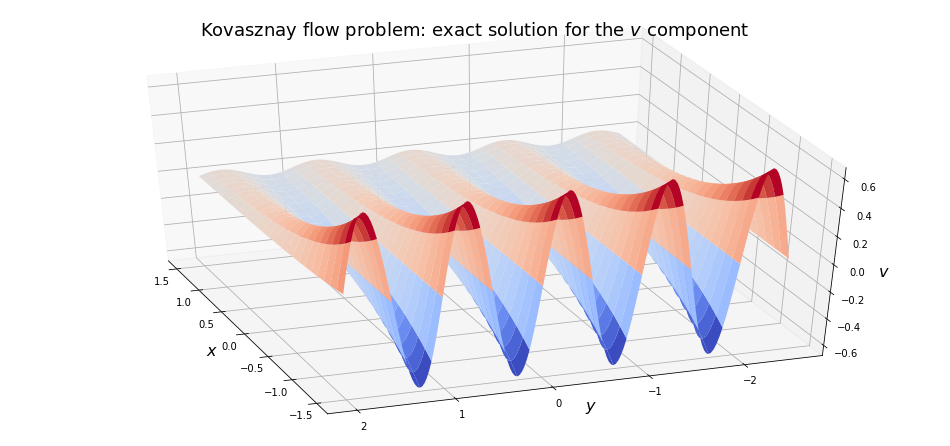

In [3]:
def kovasznay_flow(t, x, y, Re):
    p0 = 1.
    Lambda = Re/2.-sqrt(Re**2/4.+4*pi**2)
    return (1.-exp(Lambda*x)*cos(2.*pi*y),\
            Lambda/(2.*pi)*exp(Lambda*x)*sin(2.*pi*y),\
            p0-1./2*exp(2.*Lambda*x))

h, Re= 2.5e-2, 40.

x, y = meshgrid(arange(-1.5, 1.5, h, dtype=float64),\
                arange(-2.5, 2.0, h, dtype=float64), indexing='ij')
fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, kovasznay_flow(0., x, y, Re)[1],\
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 16})
axes.set_ylabel(r"$y$", {'fontsize': 16})
axes.set_zlabel(r"$v$", {'fontsize': 16})
axes.set_title(r"Kovasznay flow problem: exact solution for the $v$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./kovasznay_flow_exact_v.pdf')
close()

## Taylor decaying

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 1]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

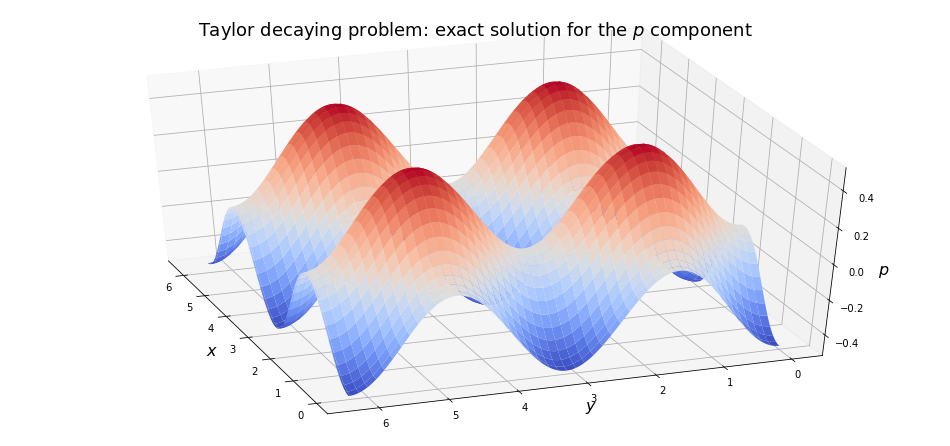

In [6]:
def taylor_decaying(t, x, y, Re):
    return (-exp(-2.*t/Re)*cos(x)*sin(y),
             exp(-2.*t/Re)*sin(x)*cos(y),
            -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.)

h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, taylor_decaying(0., x, y, Re)[2], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 16})
axes.set_ylabel(r"$y$", {'fontsize': 16})
axes.set_zlabel(r"$p$", {'fontsize': 16})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()

In [8]:
x[1, 0] - x[0, 0] == h

True